# Economic Path Analysis
### Hugo Norrby & William Wahlberg

Perform an analysis of vessel navigational paths by clustering
and classifying them based on total fuel consumption, time taken, and distance traveled.

In [4]:
import pandas as pd
from pyod.models.iforest import IForest
import seaborn as sns
from sklearn.cluster import KMeans

import numpy as np
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


In [5]:
data= pd.read_csv('Cinderella_II_Dataset.csv')
data

,engine_fuel_rate,accum_fuel_leg,engine_rpm,accelPedalPos,latitude,longitude,speedOverGround,courseOverGroundTrue,speedApparent,heading_magnetic,...,distanceToPreviousDock,delta_distance,accumDistLeg,Timestamp,accum_time_leg,sailing_state,closest_dock,segment_state,leg,RT_id
0,82.000000,0.013583,1326.416667,0.106413,59.401617,18.355397,0.448467,171.795700,4.662587,167.395300,...,17.744368,0.192010,0.375416,2022-07-01 08:54:52,0.60,un_specified,vaxholm,docking,vaxholm-sodra,0.0
1,101.333333,0.036750,1340.500000,0.131053,59.401609,18.355403,0.589003,171.795700,4.363132,167.395300,...,18.369153,0.228877,1.025822,2022-07-01 08:54:53,1.50,un_specified,vaxholm,docking,vaxholm-sodra,0.0
2,114.500000,0.069500,1379.500000,0.146299,59.401597,18.355410,0.742814,171.795700,4.006906,167.395300,...,19.411825,0.274332,1.930372,2022-07-01 08:54:54,2.55,un_specified,vaxholm,docking,vaxholm-sodra,0.0
3,120.000000,0.103833,1423.166667,0.152447,59.401582,18.355416,0.900456,171.795700,4.046811,167.395300,...,20.731121,0.331778,3.011387,2022-07-01 08:54:55,3.60,un_specified,vaxholm,docking,vaxholm-sodra,0.0
4,122.000000,0.134333,1423.083333,0.158249,59.401569,18.355422,1.056645,171.795700,4.165147,167.395300,...,21.983082,0.388637,4.119830,2022-07-01 08:54:56,4.50,un_specified,vaxholm,docking,vaxholm-sodra,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243683,28.375000,72.488531,1079.875000,-0.000833,59.401974,18.355802,0.087500,127.806862,7.480028,252.354950,...,11179.399849,0.023743,13140.684068,2022-11-06 15:22:27,1991.25,un_specified,vaxholm,docking,sodra-vaxholm,123.0
243684,35.666667,72.498028,1081.500000,0.026666,59.401974,18.355803,0.208333,173.826817,8.205154,253.009533,...,11179.395662,0.017866,13140.753436,2022-11-06 15:22:28,1992.30,un_specified,vaxholm,docking,sodra-vaxholm,123.0
243685,39.333333,72.507694,1081.416667,0.038610,59.401973,18.355803,0.208333,169.127583,8.477634,253.374350,...,11179.390546,0.015530,13140.801752,2022-11-06 15:22:29,1993.20,un_specified,vaxholm,docking,sodra-vaxholm,123.0
243686,42.000000,72.519667,1080.562500,0.024791,59.401972,18.355803,0.162500,171.542863,8.435836,254.368200,...,11179.378464,0.016695,13140.857808,2022-11-06 15:22:30,1994.25,un_specified,vaxholm,docking,sodra-vaxholm,123.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243688 entries, 0 to 243687
Data columns (total 48 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   engine_fuel_rate        243688 non-null  float64
 1   accum_fuel_leg          243688 non-null  float64
 2   engine_rpm              243688 non-null  float64
 3   accelPedalPos           243688 non-null  float64
 4   latitude                243688 non-null  float64
 5   longitude               243688 non-null  float64
 6   speedOverGround         243688 non-null  float64
 7   courseOverGroundTrue    243688 non-null  float64
 8   speedApparent           243688 non-null  float64
 9   heading_magnetic        243688 non-null  float64
 10  pitch                   243688 non-null  float64
 11  roll                    243688 non-null  float64
 12  rateOfTurn              243688 non-null  float64
 13  course_heading_diff     243688 non-null  float64
 14  magnetic_variation  

## Preprocessing

In [7]:
data_trips = data.groupby('RT_id').max(numeric_only=True)
data_trips = data_trips.rename(columns={"accum_fuel_leg": "total_fuel", "accumDistLeg": "distance", "accum_time_leg": "trip_time"})
data_economy = data_trips[['distance', 'trip_time', 'total_fuel']]

data_economy.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 124 entries, 0.0 to 123.0
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   distance    124 non-null    float64
 1   trip_time   124 non-null    float64
 2   total_fuel  124 non-null    float64
dtypes: float64(3)
memory usage: 3.9 KB


## Clustering

<Axes: xlabel='distance', ylabel='trip_time'>

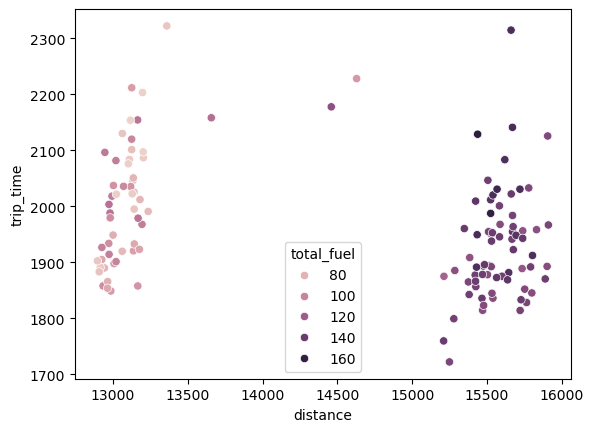

In [8]:
sns.scatterplot(data=data_economy, x='distance', y='trip_time', hue='total_fuel')

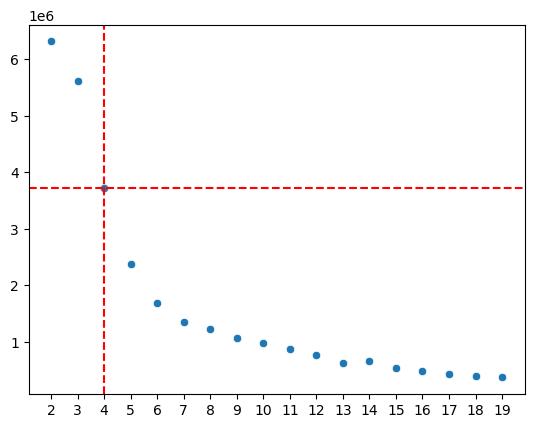

In [40]:
#sns.scatterplot(data=data_economy, x='distance', y='total_fuel', hue='trip_time')

inertia = []
ks = range(2,20)
for k in ks:
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(data_economy)
    inertia.append(kmeanModel.inertia_)

sns.scatterplot(x=[str(i) for i in ks], y=inertia)

# Chosen Cluster Amounts
cluster_amount = 4

plt.axvline(x=cluster_amount-2, color='red', linestyle='--')
plt.axhline(y=inertia[cluster_amount-2], color='red', linestyle='--')
plt.show()

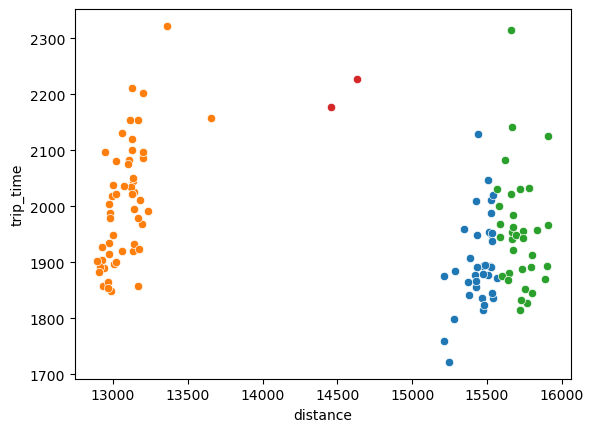

In [10]:
clusterLabels = KMeans(n_clusters=cluster_amount, n_init='auto').fit(data_economy).labels_

for c in range(cluster_amount):
    sns.scatterplot(data=data_economy[clusterLabels == c], x='distance', y='trip_time')


(68451, 48)
(104308, 48)
(66521, 48)
(4408, 48)


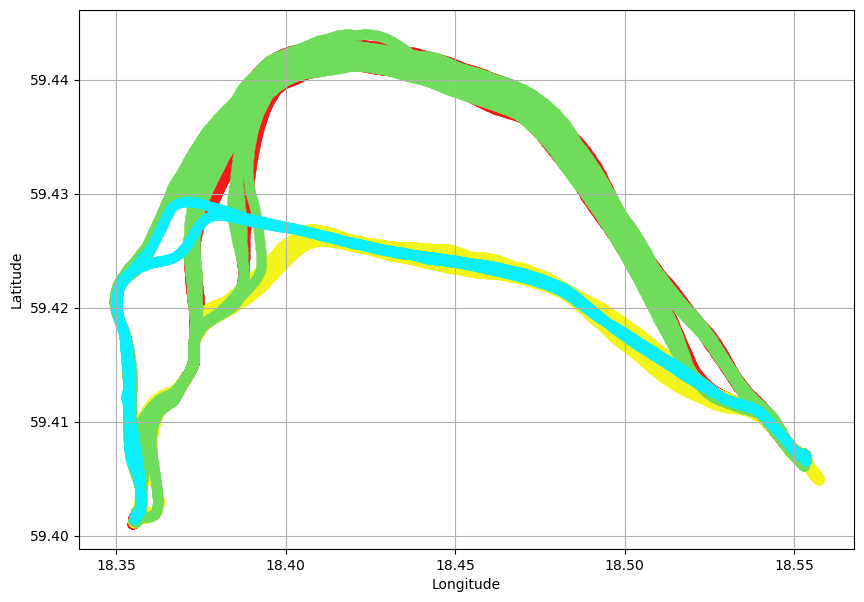

In [35]:
# Create a scatter plot of latitude and longitude to visualize the ferry's path
fig = plt.figure(figsize=(10,7))

colors = ["#f41b1b", "#f3f41b", "#70dc5b", "#0beefd", "#0027a9", "#a416dc", "#f213b6"]

for i in range(cluster_amount):
    l = list(data_trips[clusterLabels == i].index)
    t = data[data['RT_id'].isin(l)]    
    print(t.shape)
    plt.scatter(t['longitude'], t['latitude'], c=colors[i])

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()
